<a href="https://colab.research.google.com/github/cmpolik/Fatvisor/blob/main/Fatvisor3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка данмных  с Google Drive


In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!du -h /content/drive/MyDrive/Colab_Notebooks/Database3.zip

471M	/content/drive/MyDrive/Colab_Notebooks/Database3.zip


In [4]:
import os
import zipfile

zip_path = '/content/drive/MyDrive/Colab_Notebooks/Database3.zip'
extract_path = '/content'

# Распаковываем
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Данные распакованы в {extract_path}")

Данные распакованы в /content


### Проверка данных на целостность

In [5]:
base_directory = '/content/Database3/models'

# Функция для проверки вложенных директорий
def check_nested_directories(base_path):
    issues = []

    for root, dirs, files in os.walk(base_path):
        if root != base_path:
            png_files = [f for f in files if f.endswith('.png')]

            if len(png_files) != 3:
                issues.append({
                    'directory': root,
                    'png_count': len(png_files),
                    'files': png_files
                })

    return issues

issues = check_nested_directories(base_directory)

if issues:
    print("Найдены директории с проблемами:")
    for issue in issues:
        print(f"\nДиректория: {issue['directory']}")
        print(f"Количество PNG: {issue['png_count']}")
        print(f"Файлы: {issue['files']}")
else:
    print("Все вложенные директории содержат ровно 3 PNG файла.")



Все вложенные директории содержат ровно 3 PNG файла.


In [6]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

### MakeHuman файлы

In [7]:
# Функция для извлечения нужных данных из .mhm файла

def parse_mhm_file(filepath):
    data = {}
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith("modifier macrodetails/Gender"):
                data['Gender'] = float(line.split()[-1])
            elif line.startswith("modifier macrodetails/Age"):
                data['Age'] = float(line.split()[-1])
            elif line.startswith("modifier macrodetails-universal/Weight"):
                data['Weight'] = float(line.split()[-1])
            elif line.startswith("modifier macrodetails-height/Height"):
                data['Height'] = float(line.split()[-1])
            elif line.startswith("modifier macrodetails-universal/Muscle"):
                data['Muscle'] = float(line.split()[-1])
    return data

In [8]:
# Чтение всех .mhm файлов и сбор данных в DataFrame

def load_metadata(metadata_path):
    all_data = []
    for filename in os.listdir(metadata_path):
        if filename.endswith(".mhm"):
            filepath = os.path.join(metadata_path, filename)
            data = parse_mhm_file(filepath)
            data['model_id'] = os.path.splitext(filename)[0]  # Имя файла без расширения
            all_data.append(data)
    return pd.DataFrame(all_data)

# Указываем путь к папке с .mhm файлами
metadata_path = '/content/Database3/mhm'
metadata = load_metadata(metadata_path)

# Проверяем структуру
print(metadata.sample(n = 10, random_state = 42))


      Gender   Age  Muscle  Weight  Height   model_id
530      1.0  0.33     0.7    0.90   0.634  male_1755
1729     1.0  0.33     0.3    0.70   0.550   male_148
1010     1.0  0.33     0.3    0.45   0.676  male_2373
1149     1.0  0.33     0.5    1.00   0.606  male_1271
1383     1.0  0.33     0.5    0.35   0.704  male_2856
4102     1.0  0.33     0.2    0.65   0.620  male_1410
4857     1.0  0.33     0.6    0.85   0.718  male_3274
4915     1.0  0.33     0.1    0.80   0.550  male_4141
3966     1.0  0.33     0.8    0.50   0.718  male_3165
3011     1.0  0.33     0.5    0.25   0.718  male_3080


In [9]:
import pandas as pd

# Функция для подсчета количества каждого значения
def create_value_count_table(data):
    data = data.dropna()  # Убираем NaN
    return data.value_counts().sort_index()  # Считаем и сортируем значения

# Создаём таблицы для каждого столбца
tables = {}
columns_to_process = ["Weight", "Height", "Muscle"]

for column in columns_to_process:
    if column in metadata.columns:
        tables[column] = create_value_count_table(metadata[column])

# Вывод таблиц
for column, table in tables.items():
    print(f"Таблица для {column}:")
    print(table)
    print("\n")


Таблица для Weight:
Weight
0.25    320
0.30    320
0.35    320
0.40    320
0.45    320
0.50    320
0.55    320
0.60    320
0.65    320
0.70    320
0.75    320
0.80    320
0.85    320
0.90    320
0.95    320
1.00    320
Name: count, dtype: int64


Таблица для Height:
Height
0.550    320
0.564    320
0.578    320
0.592    320
0.606    320
0.620    320
0.634    320
0.648    320
0.662    320
0.676    320
0.690    320
0.704    320
0.718    320
0.732    320
0.746    320
0.760    320
Name: count, dtype: int64


Таблица для Muscle:
Muscle
0.1    512
0.2    512
0.3    512
0.4    512
0.5    512
0.6    512
0.7    512
0.8    512
0.9    512
1.0    512
Name: count, dtype: int64




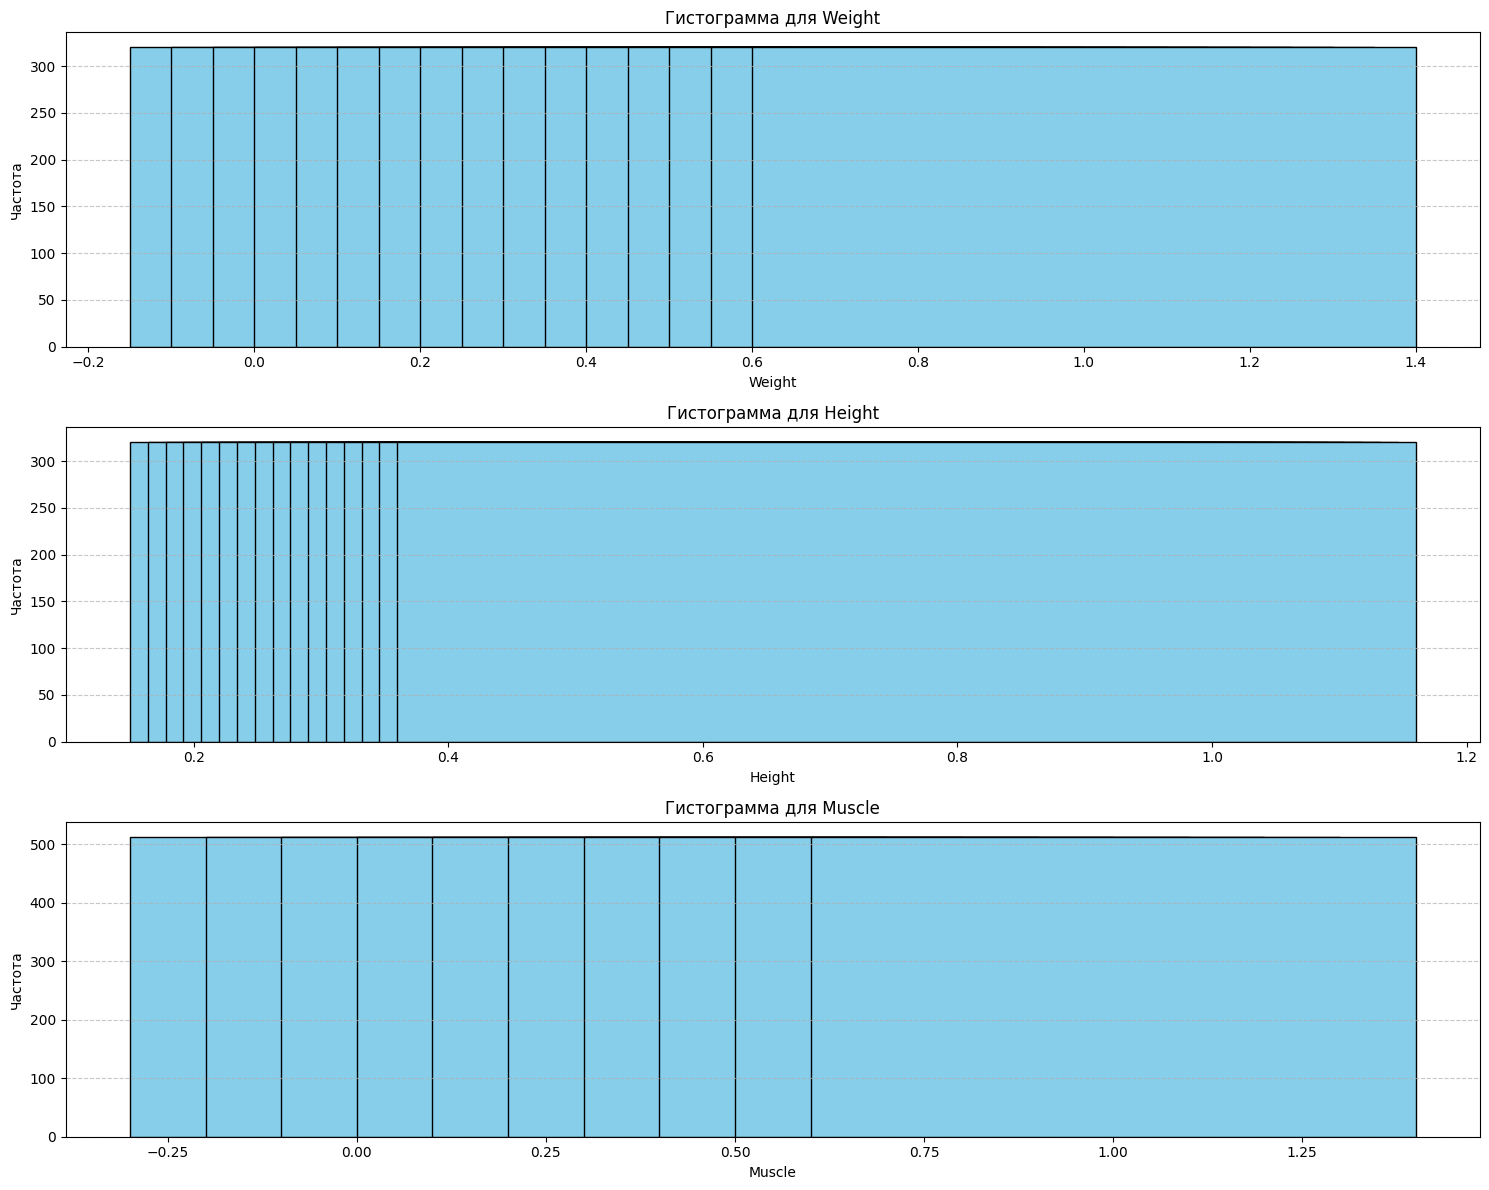

In [10]:
# Функция для построения гистограммы по данным таблицы
def plot_histogram(value_counts, column_name):
    values = value_counts.index
    frequencies = value_counts.values

    plt.bar(values, frequencies, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма для {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Создаём гистограммы для weight, height и muscles
plt.figure(figsize=(15, 12))

columns_to_plot = ["Weight", "Height", "Muscle"]
for i, column in enumerate(columns_to_plot, start=1):
    if column in tables:  # Используем таблицы из предыдущего шага
        plt.subplot(3, 1, i)
        plot_histogram(tables[column], column)

# Показываем все гистограммы
plt.tight_layout()
plt.show()


In [11]:
# Нормализация данных: Age, Weight, Height
scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_features(df, features):
    df[features] = scaler.fit_transform(df[features])
    return df

features_to_normalize = ['Age', 'Weight', 'Height']
metadata = normalize_features(metadata, features_to_normalize)

In [12]:
df = metadata.drop(columns= ["Gender", "Age"])
df.head()

,Muscle,Weight,Height,model_id
0,0.2,0.133333,0.800000,male_3106
1,0.7,0.400000,0.333333,male_4443
2,0.9,1.000000,1.000000,male_4094
3,1.0,0.200000,0.266667,male_4368
4,0.4,0.666667,0.466667,male_4586


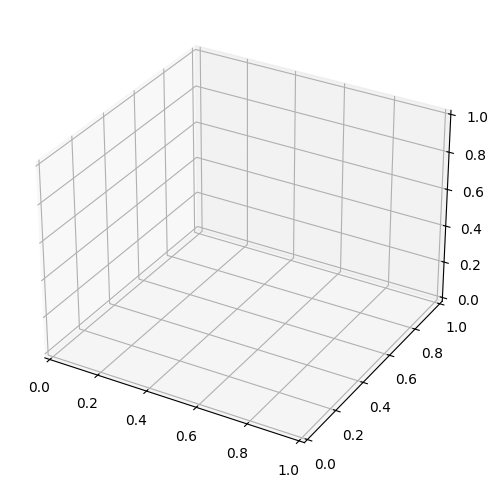

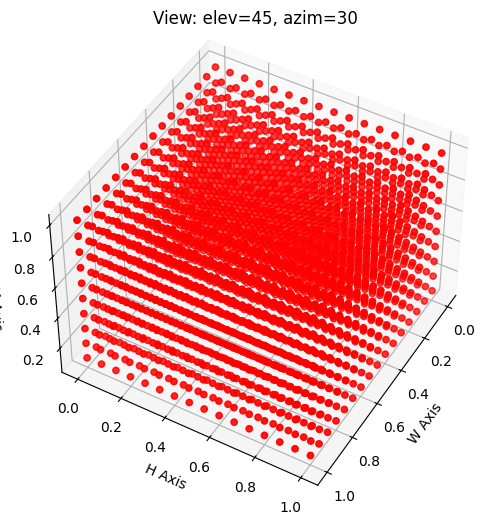

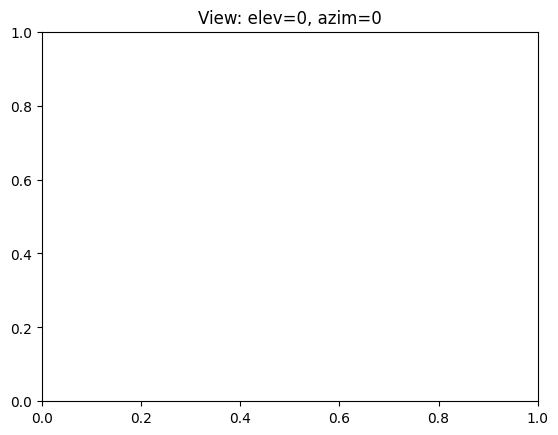

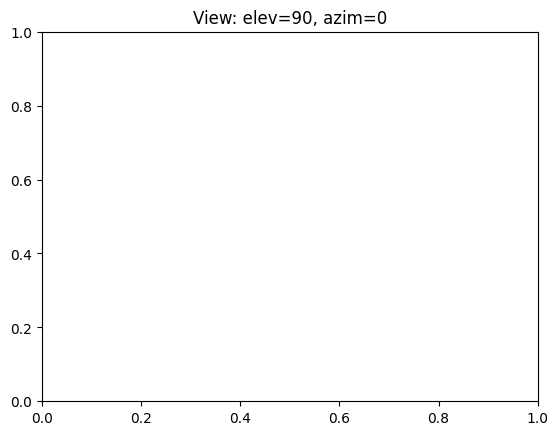

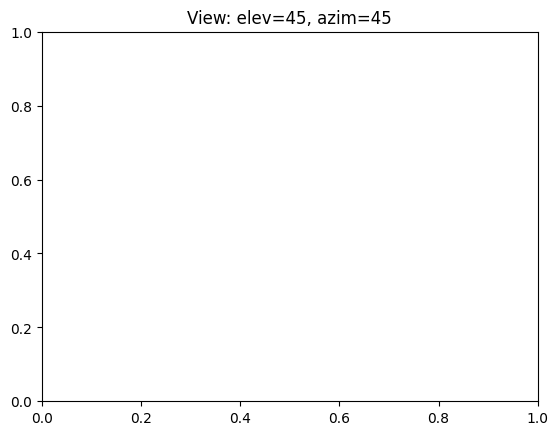

In [13]:
# график зависимости всех трех параметров

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(df['Weight'], df['Height'], df['Muscle'], c='r', marker='o')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Weight'], df['Height'], df['Muscle'], c='r', marker='o')

ax.set_xlabel('W Axis')
ax.set_ylabel('H Axis')
ax.set_zlabel('M Axis')

angles = [(45, 30), (0, 0), (90, 0), (45, 45)]  # Список углов (elev, azim)
for elev, azim in angles:
    ax.view_init(elev=elev, azim=azim)
    plt.title(f"View: elev={elev}, azim={azim}")
    plt.show()


### Загрузка изображений по ID

In [14]:
# Путь к основной директории с изображениями
image_root = '/content/Database3/models'

# Функция для загрузки трех изображений из директории по ID
def load_images_from_dir(id, image_shape):
    dir_path = tf.strings.join([image_root, "/", id, "/"])

    front_path = tf.strings.join([dir_path, "front.png"])
    side_path = tf.strings.join([dir_path, "side.png"])
    back_path = tf.strings.join([dir_path, "back.png"])

    def load_and_process_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)  # Grayscale
        img = tf.image.resize(img, image_shape[:2])
        img = img / 255.0  # Нормализация

        # Дублируем канал для создания 3-канального изображения
        img = tf.image.grayscale_to_rgb(img)
        return img

    front = load_and_process_image(front_path)
    side = load_and_process_image(side_path)
    back = load_and_process_image(back_path)
    return front, side, back


### Создание датасета с возможностью загрузки изображений батчами

In [15]:
def create_dataset(df, batch_size, image_shape):
    ids = df['model_id'].values
    numeric_data = df[['Weight', 'Height']].values
    targets = df['Muscle'].values

    dataset = tf.data.Dataset.from_tensor_slices((ids, numeric_data, targets))

    def process_data(id, numeric, target):
        # Загружаем изображения
        front, side, back = load_images_from_dir(id, image_shape)
        # Возвращаем входы и цель
        return ((front, side, back, numeric), target)

    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Кэшируем данные (если они не изменяются после первого чтения)
    dataset = dataset.cache()

    # Батчи и предварительная загрузка
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
                                                          # tuple -> ((front, side, back, numeric), target)

In [16]:
# перемешаем данные в датафрейм и передадим их на преобразование теназоры и создание dataset

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
#разделение на 80/15/5
train_df, val_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

In [18]:
batch_size = 64
image_shape = (224, 224, 3)

train_dataset = create_dataset(train_df, batch_size, image_shape)
val_dataset = create_dataset(val_df, batch_size, image_shape)
test_dataset = create_dataset(test_df, batch_size, image_shape)

###Архитектура модели

In [19]:
# --- Входные данные ---
input_front = Input(shape=(224, 224, 3), name='front_image')
input_side = Input(shape=(224, 224, 3), name='side_image')
input_back = Input(shape=(224, 224, 3), name='back_image')
input_numeric = Input(shape=(2,), name='numeric_data')

In [20]:
# --- Feature Extractors ---
def build_resnet(input_layer, model_name):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), name=model_name)
    #base_model.trainable = False #замарозка весов
    # Замораживаем все слои, кроме последних 4
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)  # Усреднение признаков
    return x

In [21]:
# Извлекаем признаки для каждого изображения
features_front = build_resnet(input_front, model_name="resnet_front")
features_side = build_resnet(input_side, model_name="resnet_side")
features_back = build_resnet(input_back, model_name="resnet_back")

In [22]:
# --- Fusion Layer ---
merged_features = Concatenate()([features_front, features_side, features_back, input_numeric])

In [23]:
# --- Полносвязные слои ---
x = Dense(256, activation='relu')(merged_features)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

In [24]:
# --- Выход ---
output = Dense(1, activation='linear', name='output')(x)

In [25]:
# --- Модель ---
model = Model(inputs=[input_front, input_side, input_back, input_numeric], outputs=output)

In [26]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [28]:
# Вывод структуры модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ front_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ side_image (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ back_image (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet_front (Functional) │ (None, 7, 7, 2048)     │     23,587,712 │ front_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet_side (Functional)  │ (None, 7, 7, 2048)     │     23,587,712 │ side_image[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet_back (Functional)  │ (None, 7, 7, 2048)     │     23,587,712 │ back_image[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet_front[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet_side[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet_back[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_data (InputLayer) │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6146)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ numeric_data[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,573,632 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)  

 Total params: 72,380,033 (276.11 MB)

 Trainable params: 15,013,889 (57.27 MB)

 Non-trainable params: 57,366,144 (218.83 MB)

### Обучени

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# Раннее прекращение
early_stopping = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)


In [30]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 922ms/step - loss: 0.3287 - mae: 0.4341 - val_loss: 0.1657 - val_mae: 0.3304
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - loss: 0.1177 - mae: 0.2831 - val_loss: 0.1268 - val_mae: 0.2969
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 626ms/step - loss: 0.1086 - mae: 0.2731 - val_loss: 0.1054 - val_mae: 0.2725
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 625ms/step - loss: 0.0977 - mae: 0.2652 - val_loss: 0.0790 - val_mae: 0.2436
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - loss: 0.0895 - mae: 0.2568 - val_loss: 0.0799 - val_mae: 0.2442
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - loss: 0.0883 - mae: 0.2550 - val_loss: 0.0796 - val_mae: 0.2441
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - loss: 0.0866 - mae: 0.2532 - val_loss: 0.0796 - val_mae: 0.2440
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - loss: 0.0858 - mae: 0.2517 - val_loss: 0.0796 - val_mae: 0.2440
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 638ms

### njnkj

In [ ]:
# Сохранение только весов модели
model.save_weights('/content/fatv3_liner_weights.weights.h5')  # Замените путь на ваш


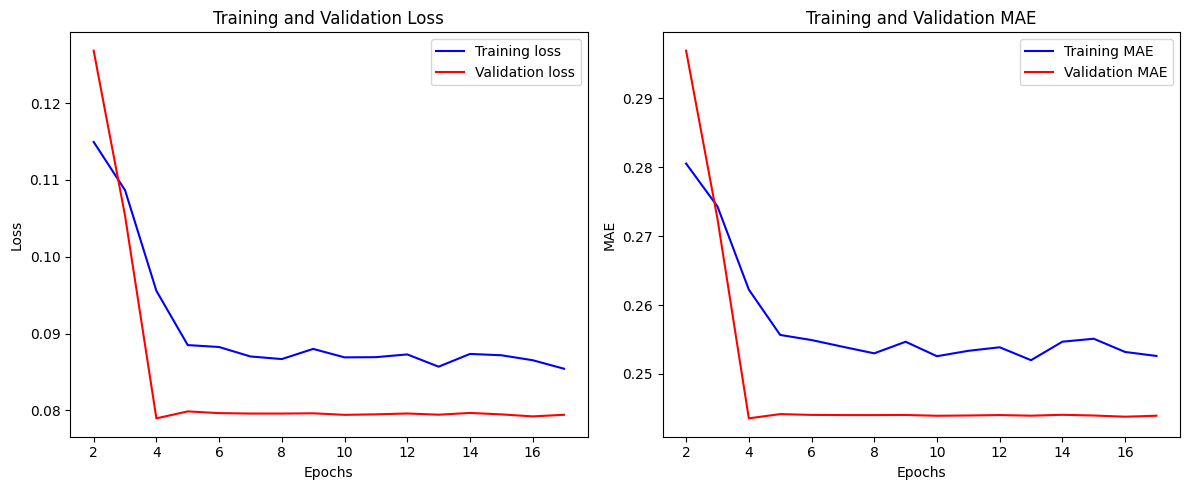

In [31]:
import matplotlib.pyplot as plt

# Данные из истории обучения
loss = history.history['loss'][1:]  # Пропускаем первое значение
val_loss = history.history['val_loss'][1:]  # Пропускаем первое значение
mae = history.history['mae'][1:]  # Пропускаем первое значение
val_mae = history.history['val_mae'][1:]  # Пропускаем первое значение

# Эпохи (корректируем номера эпох, начиная с 2)
epochs = range(2, len(history.history['loss']) + 1)

# Построение графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Оценка модели на тестовом наборе
test_loss, test_mae = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")




KeyboardInterrupt: 

In [ ]:
# Предсказания модели
predictions = model.predict(test_dataset)

# Анализ первых 10 предсказаний
for i in range(100):
    print(f"True Value: {test_df['Muscle'].iloc[i]}, Predicted: {predictions[i]}")


In [ ]:
# Истинные значения
true_values = test_df['Muscle'].values

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6, label='Predictions vs True')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Ideal Fit')
plt.xlabel('True Muscle')
plt.ylabel('Predicted Muscle')
plt.title('True vs Predicted Muscle')
plt.legend()
plt.show()
